# Dataset Processing

## Structure of the data file

The raw dataset generated using the `generate_dataset.ipynb` is a folder contains many `npz` files. The name of each `npz` file is `(name of airfoil)_(free-stream velocity)_(angle of attack)_(idx simulation iteration)`. For example, the name `raf30_7864_1813_2670.npz` represents that this file is the flow field generated by the parameter set {airfoil=raf30, free-stream velocity=78.64 $m/s$, angle of attack = 18.13 $\degree$, simulation iteration=2670}.

The dataset file can be simply read using numpy:

(6, 128, 128)


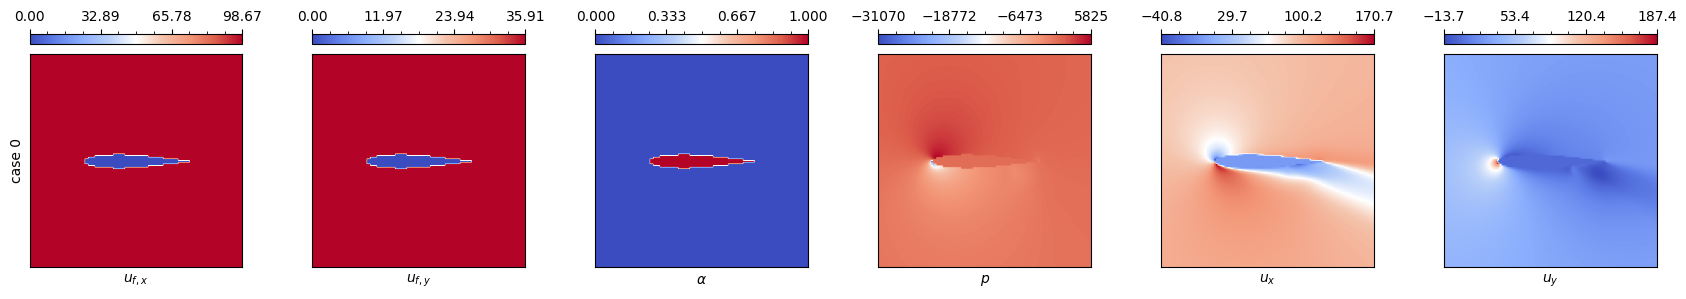

In [3]:
import zipfile,os
from tqdm import tqdm
import numpy as np
from airfoil_diffusion.plotter import show_each_channel

if not os.path.exists("./datasets/1_parameter/data/"):
    files=[file for file in os.listdir("./datasets/1_parameter/") if file.endswith(".zip")]
    for file in tqdm(files): 
        f=zipfile.ZipFile("./datasets/1_parameter/"+file,'r')
        for file in f.namelist():
            f.extract(file,"./datasets/1_parameter/data/")
        f.close()   
data_sample=np.load("./datasets/1_parameter/data/raf30_10500_2000_2510.npz")["a"]
# Or use:
# data_sample=read_single_file("./datasets/1_parameter/data/raf30_10500_2000_2510.npz")
print(data_sample.shape)
show_each_channel(data_sample,channel_names=["$u_{f,x}$","$u_{f,y}$",r"$\alpha$","$p$","$u_x$","$u_y$"],transpose=True)

The first three channels of the datafile are the x and y components of free-stream velocity and the angle of attack. The last three channels are the distribution of pressure and velocity components.

## Organize data files

We provide `DataFiles` class to organize our dataset. `DataFiles` has two child classes named `FolderDataFiles` and `FileDataFiles`. The folder contains all the simulation data can be accessed via the `FolderDataFiles` class:

In [4]:
from airfoil_diffusion.airfoil_datasets import *
folder_df=FolderDataFiles("./datasets/1_parameter/data/")

`DataFiles` class is iterable and has many useful functions:
* `DataFiles` is iterable:

In [5]:
for case_i in folder_df:
    print(case_i)
    break
print(folder_df[0:2])

{'airfoil': 'raf30', 'velocity': 75.0, 'AoA': 20.0, 'time_tag': 3230.0, 'file_name': 'raf30_7500_2000_3230.npz', 'path': './datasets/1_parameter/data/'}
[{'airfoil': 'raf30', 'velocity': 75.0, 'AoA': 20.0, 'time_tag': 3230.0, 'file_name': 'raf30_7500_2000_3230.npz', 'path': './datasets/1_parameter/data/'}, {'airfoil': 'raf30', 'velocity': 105.0, 'AoA': 20.0, 'time_tag': 2860.0, 'file_name': 'raf30_10500_2000_2860.npz', 'path': './datasets/1_parameter/data/'}]


* Get names of airfoils in current data files:

In [6]:
folder_df.get_airfoil_names()

['raf30']

* Get the path of certain data file:

In [7]:
folder_df.get_case_path(0)
#folder_df[0]['path']+folder_df[0]['file_name']

'./datasets/1_parameter/data/raf30_7500_2000_3230.npz'

* Sort the data files according to given key:

In [8]:
folder_df.sort(key="velocity")

* Separate the data files with the same airfoil shape, free-stream velocity, and angle of attack: 

In [9]:
simulation_case=folder_df.get_simulation_cases()
simulation_case

[{'airfoil': 'raf30', 'velocity': 5.0, 'AoA': 20.0},
 {'airfoil': 'raf30', 'velocity': 15.0, 'AoA': 20.0},
 {'airfoil': 'raf30', 'velocity': 25.0, 'AoA': 20.0},
 {'airfoil': 'raf30', 'velocity': 35.0, 'AoA': 20.0},
 {'airfoil': 'raf30', 'velocity': 45.0, 'AoA': 20.0},
 {'airfoil': 'raf30', 'velocity': 55.0, 'AoA': 20.0},
 {'airfoil': 'raf30', 'velocity': 65.0, 'AoA': 20.0},
 {'airfoil': 'raf30', 'velocity': 75.0, 'AoA': 20.0},
 {'airfoil': 'raf30', 'velocity': 85.0, 'AoA': 20.0},
 {'airfoil': 'raf30', 'velocity': 95.0, 'AoA': 20.0},
 {'airfoil': 'raf30', 'velocity': 105.0, 'AoA': 20.0}]

* Select the simulation case with given airfoil shape, free-stream velocity and angle of attack

In [10]:
folder_df.select_simulation_cases(simulation_case[0:1])[0:2]

[{'airfoil': 'raf30',
  'velocity': 5.0,
  'AoA': 20.0,
  'file_name': 'raf30_500_2000_3470.npz',
  'path': './datasets/1_parameter/data/',
  'time_tag': 3470.0},
 {'airfoil': 'raf30',
  'velocity': 5.0,
  'AoA': 20.0,
  'file_name': 'raf30_500_2000_3130.npz',
  'path': './datasets/1_parameter/data/',
  'time_tag': 3130.0}]

These functions can be useful for analyzing the data. For example, we can check the mean and standard deviation of the flow filed corresponding to the case of `{'airfoil': 'raf30', 'velocity': 105.0, 'AoA': 20.0}` through:

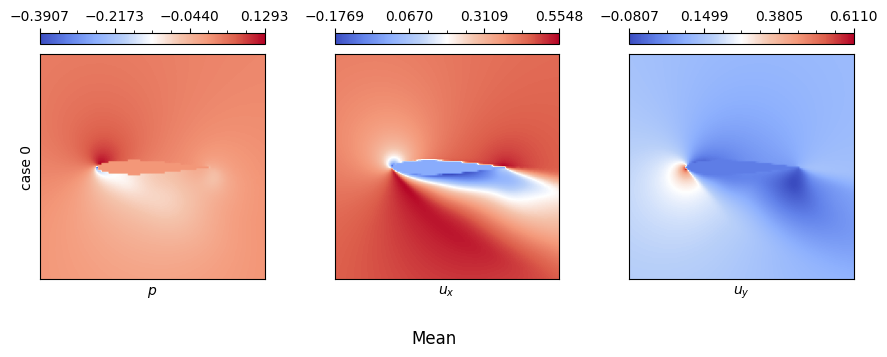

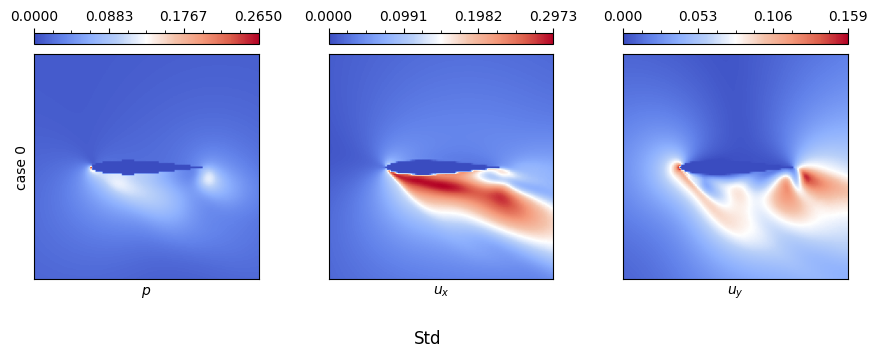

In [11]:
selected_cases=folder_df.select_simulation_cases([folder_df.get_simulation_cases()[-1]])
datas=[]
for case in selected_cases:
    datas.append(
        read_single_file(case['path']+case['file_name'])[3:]
        )
show_each_channel(np.stack(datas,axis=0).mean(axis=0),channel_names=["$p$","$u_x$","$u_y$"],title="Mean",transpose=True)
show_each_channel(np.stack(datas,axis=0).std(axis=0),channel_names=["$p$","$u_x$","$u_y$"],title="Std",transpose=True)

Another major use for `FolderDataFiles` is to generate a smaller dataset from a huge one. For example, each simulation case (i.e., case with the same airfoil shape, free-stream velocity, and angle of attack) has 100 samples from different simulation iterations. We can simply generate a smaller dataset with only 25 samples and divide it into training and test dataset: 

In [10]:
iteration_tag_25=[2540+i*40 for i in range(25)]
test_velocities=[5.0 +20*i for i in range(6)]
train_velocities=[15.0 +20*i for i in range(5)]
selected_training_cases=[]
selected_test_cases=[]
for case_i in folder_df:
    if case_i["time_tag"] in iteration_tag_25:
        if case_i["velocity"] in train_velocities:
            selected_training_cases.append(case_i)
        elif case_i["velocity"] in test_velocities:
            selected_test_cases.append(case_i)
print(len(selected_training_cases),len(selected_test_cases))
save_case_list_to_filedataFiles(selected_training_cases,"./datasets/1_parameter/train_cases.txt")
save_case_list_to_filedataFiles(selected_test_cases,"./datasets/1_parameter/test_cases.txt")

125 150


The generated file can then be read through `FileDataFiles` class:

In [11]:
train_df=FileDataFiles("./datasets/1_parameter/train_cases.txt",base_path="./datasets/1_parameter/data/")
test_df=FileDataFiles("./datasets/1_parameter/test_cases.txt",base_path="./datasets/1_parameter/data/")
train_df[0:2]

[{'airfoil': 'raf30',
  'velocity': 15.0,
  'AoA': 20.0,
  'time_tag': 2980.0,
  'file_name': 'raf30_1500_2000_2980.npz',
  'path': './datasets/1_parameter/data/'},
 {'airfoil': 'raf30',
  'velocity': 15.0,
  'AoA': 20.0,
  'time_tag': 2700.0,
  'file_name': 'raf30_1500_2000_2700.npz',
  'path': './datasets/1_parameter/data/'}]

Finally, we can generate the dataset used for training/test. The `AirfoilDataset` class uses an instance of datafiles as a parameter, and the instance could be from both `FolderDataFiles`, `FileDataFiles`, and `DataFiles`:

In [12]:
dataset_train=AirfoilDataset(train_df)
#dataset_train=AirfoilDataset(DataFiles(selected_training_cases))
dataset_test=AirfoilDataset(test_df)
#dataset_test=AirfoilDataset(DataFiles(selected_test_cases))
#dataset_full=AirfoilDataset(FolderDataFiles("./datasets/1_parameter/data/"))

Loading datas: 100%|██████████| 150/150 [00:00<00:00, 470.66it/s]
